# **Exercise**    -  Bike Sharing Demand Prediction



# **Summary**

The **Seoul Bike Sharing Demand Dataset** provides data on the number of rented bikes for every hour of the day in Seoul, South Korea, from **December 2017 to November 2018**. The data is useful for understanding bike rental trends and predicting bike rental demand.

The first phase of the project involved data wrangling. I created new features like **Day**, **Month**, **Year**, **weekday** etc. from the Date column that will help in EDA as well as modelling, and converted data types of columns like Year, Month, Day to categorical type. Found out that around 295 rows of data had 0 Rented Bike Count since it was non functioning day. Also created **Temperature Bin** to help mainly in visualization of bike demand trend over different temperatures.

In the second phase, I conducted exploratory data analysis (EDA) to identify trends and patterns in the data. Some of the important findings are: demand for rented bikes increases as temperature increases to a certain level, demand was higher during non-holiday days, demand was lowest during winter and highest during summer, rainfall and snowfall had a negative impact on demand, demand is high during rush hours of the day etc.
I used different types of charts like Histogram, Box Plot, Scatter Plot, Line Chart, Bar Chart, Correlation Heatmap etc.

Next, I conducted hypothesis testing to validate my findings from EDA. I used **two-sample t-tests** to test whether rented bike demand was higher in hot weather and during rush hour. I also used **one-way ANOVA** tests to test whether rented bike demand was different in different seasons. The results of these tests confirmed my findings from EDA.

The fourth phase involved feature engineering. I capped outliers in Wind speed, Solar Radiation, Rainfall, and Snowfall using different methods like **99th percentile** and **IQR**. I also used one-hot encoding for categorical features like Seasons, Holiday, and Functioning Day. I created a new feature called is_weekend to indicate whether a day was a weekend day. Using VIF method, I dropped the Dew point temperature feature to reduce VIF factor to acceptable levels. After that did applied data scaling to some columns that needed it using methods like **StandardScaler** and **MinMaxScaler**.

Next, I used five different machine learning models – Linear Regression, Ridge Regression, Decision Tree, Random Forest, and XGBoost – to predict rented bike demand. Using **GridSearchCV** and **RandomSearchCV**, I tuned the hyperparameters for each model and used cross-validation to evaluate their performance. Hyperparameter optimized **XGBoost gave the best results**, with an $R^2$ of **0.94** and an $MSE$ of **8.356**.

Finally, I used SHAP values to interpret the XGBoost model. I found that Hour, Temperature, and Humidity were some of the most important features for predicting bike rental demand. Hour and Temperature had positive impact on demand whereas Humidity has negative impact in demand.

In conclusion, this project shows that bike rental demand in Seoul is influenced by weather conditions, day of the week, and season. To increase bike rental demand, companies can focus on promoting bike rental during good weather, non-holiday days, summer season etc. In addition to that, companies can use the insights gained from this project to optimize their rental pricing and inventory management.

# **Problem Statement**


**BUSINESS PROBLEM OVERVIEW**


The business problem is to ensure a stable supply of rental bikes in urban cities by predicting the demand for bikes at each hour. By providing a stable supply of rental bikes, the system can enhance mobility comfort for the public and reduce waiting time, leading to greater customer satisfaction.

To address this problem, we need to develop a predictive model that takes into account various factors that may influence demand, such as time of day, seasonality, weather conditions, and holidays. By accurately predicting demand, the bike sharing system operators can ensure that there is an adequate supply of bikes available at all times, which can improve the user experience and increase usage of the bike sharing system. This can have a positive impact on the sustainability of urban transportation, as it can reduce congestion, air pollution, and greenhouse gas emissions.

## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of the day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

!pip install shap==0.40.0
import shap
import graphviz

import pickle

sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

### Dataset Loading

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/ML/Class 1 - EDA/Datasets/SeoulBikeData.csv", encoding='ISO-8859-1')


### Dataset First View

In [ ]:
# Dataset First Look
df.head(10)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,0.0,Winter,No Holiday,Yes
5,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0.00,0.0,0.0,Winter,No Holiday,Yes
6,01/12/2017,181,6,-6.6,35,1.3,2000,-19.5,0.00,0.0,0.0,Winter,No Holiday,Yes
7,01/12/2017,460,7,-7.4,38,0.9,2000,-19.3,0.00,0.0,0.0,Winter,No Holiday,Yes
8,01/12/2017,930,8,-7.6,37,1.1,2000,-19.8,0.01,0.0,0.0,Winter,No Holiday,Yes
9,01/12/2017,490,9,-6.5,27,0.5,1928,-22.4,0.23,0.0,0.0,Winter,No Holiday,Yes


### Dataset Rows & Columns count

In [ ]:
# Dataset Rows & Columns count
df.shape

(8760, 14)

### Dataset Information

In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

#### Duplicate Values

In [ ]:
# Dataset Duplicate Value Count
df.duplicated().sum()


0

#### Missing Values/Null Values

In [ ]:
# Missing Values/Null Values Count
df.isna().sum().sum()

0

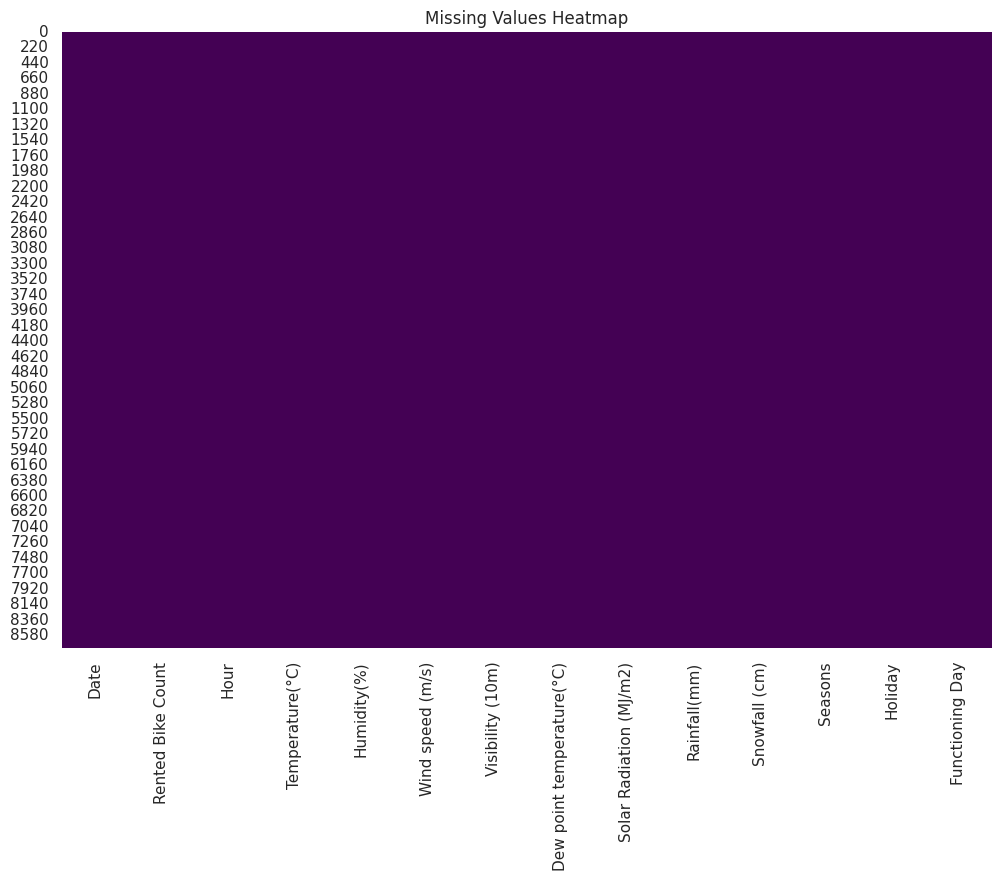

In [ ]:
# Visualizing the missing values
plt.figure(figsize=(12, 8))
plt.title("Missing Values Heatmap")
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.show()

### What did you know about your dataset?

The size of the dataset is 8760 rows and 14 columns.
The dataset is clean, with no null value or duplicate data.

## ***2. Understanding Your Variables***

In [ ]:
# Dataset Columns
df.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [ ]:
# Dataset Describe
df.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


### Check Unique Values for each variable.

In [ ]:
# Check Unique Values for each variable.
for i in df.columns.tolist():
  print("No. of unique values in ",i,"is",df[i].nunique())

No. of unique values in  Date is 365
No. of unique values in  Rented Bike Count is 2166
No. of unique values in  Hour is 24
No. of unique values in  Temperature(°C) is 546
No. of unique values in  Humidity(%) is 90
No. of unique values in  Wind speed (m/s) is 65
No. of unique values in  Visibility (10m) is 1789
No. of unique values in  Dew point temperature(°C) is 556
No. of unique values in  Solar Radiation (MJ/m2) is 345
No. of unique values in  Rainfall(mm) is 61
No. of unique values in  Snowfall (cm) is 51
No. of unique values in  Seasons is 4
No. of unique values in  Holiday is 2
No. of unique values in  Functioning Day is 2


## 3. ***Data Wrangling***

### Data Wrangling Code

In [ ]:
# Create a copy of the current dataset and assigning to df
df1 = df.copy()
df1.shape

(8760, 14)

In [ ]:
# Changing the "Date" column dtype to datetime
df1['Date'] = pd.to_datetime(df1['Date'], format="%d/%m/%Y")

In [ ]:
# Creating new columns Year, Month, Day
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month
df1['Day'] = df1['Date'].dt.day
df1['weekday'] = df1['Date'].dt.day_name()  # we better understand names (monday, friday etc) instead of numbers

In [ ]:
df1.head(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,Friday
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,Friday
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,Friday


In [ ]:
# Unique hours
df1['Hour'].unique()    # It is in 24hrs format

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
# Changing Hour, Year, Month dtypes to categorical
for col in ['Year', 'Month', 'Day']:
  df1[col] = df1[col].astype('category')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

In [ ]:
# Creating Temperature bin of 1°C intervals that will help in visualizations
df1['Temperature Bin'] = df1['Temperature(°C)'].round(0).astype('int64')

### What all manipulations have you done and insights you found?

First of all I checked for duplicate data and missing values, found 0 in both cases. Changed datatype of **Date** column which represent the date of observing the data to datetime to better access the data functions provided by pandas. I created new features like **Day**, **Month**, **Year**, **weekday** from Date column that will help better in visualizations as well as modelling as it can help getting insight any trend over day or month or weekday etc. I found out that dataset contains information from Dec 2017 to Nov 2018, so we don't have enough data to find patterns/trends over years. Converted Year, Month, Day to categorical data type. Created new feature **Temperature bin** which will help mainly in visualizing the trend of demand over temperatures.

Although visualization is better to get insight of the data that will be done in next section, I tried to understand bike rentals demand levels accross seasons (summer has highest demand and winter has lowest), Holiday has less demand compared to non holiday maybe because there are more people who use rented bikes to go to offices, schools etc on non holiday. As expected non functioning day has zero demand. We may need to drop all the rows with non functioning day as we'll be trying to predict demand when the rental bike service is functioning.

## ***6. Feature Engineering & Data Pre-processing***

### 1. Handling Missing Values

In [ ]:
# Checking missing values
df1.isna().sum().sum()

0

#### What all missing value imputation techniques have you used and why did you use those techniques?

There are no missing values to handle in the given dataset.

### 2. Handling Outliers

In [ ]:
# From chart 16 above, we know following columns have outliers
outlier_cols = ['Wind speed (m/s)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

In [ ]:
# Upper & Lower Boundary using IQR method
def getOutlierBoundaryIQR(df, feature):
  IQR= df1[feature].quantile(0.75)- df1[feature].quantile(0.25)
  lower_bridge =df1[feature].quantile(0.25)-3*IQR
  upper_bridge =df1[feature].quantile(0.75)+3*IQR
  return upper_bridge,lower_bridge

In [ ]:
# Unique values and their counts for Rainfall(mm)
df1['Rainfall(mm)'].value_counts()

,count
Rainfall(mm),
0.0,8232
0.5,116
1.0,66
1.5,56
0.1,46
...,...
1.9,1
3.3,1
17.0,1


We see that most of rows have value 0.0 and very few fave non-zero value. Which is understandable because we don't see rain everyday. Given the nature of data, it is unlikely that the non-zero values represent outliers. However value that is significantly higher can be treated as outlier.

In [ ]:
# Upper & Lower boundary for Rainfall(mm) using IQR method
ub, lb = getOutlierBoundaryIQR(df1, 'Rainfall(mm)')
print(f"Boundary: [{ub}, {lb}]")
print("99th Percentile:", df1['Rainfall(mm)'].quantile(0.99))

Boundary: [0.0, 0.0]
99th Percentile: 4.0


We see both boundries from IQR method are zero because of **majority of data being zero** and is **not normally distributed**. So we'll apply **99th quantile** for capping outlier.

In [ ]:
# Applying outlier capping using 99th percentile
rainfall_99th = df1['Rainfall(mm)'].quantile(0.99)
df1['Rainfall(mm)_capped'] = df1['Rainfall(mm)'].clip(upper=rainfall_99th)

In [ ]:
# Upper & Lower boundary using IQR method
ub, lb = getOutlierBoundaryIQR(df1, 'Snowfall (cm)')
print(f"Boundary: [{ub}, {lb}]")
print("99th Percentile:", df1['Snowfall (cm)'].quantile(0.99))

Boundary: [0.0, 0.0]
99th Percentile: 2.5


Similarly case for **Snowfall (cm)** as in **Rainfall(mm)**

In [ ]:
# Applying outlier capping using 99th percentile
snowfall_99th = df1['Snowfall (cm)'].quantile(0.99)
df1['Snowfall(cm)_capped'] = df1['Snowfall (cm)'].clip(upper=snowfall_99th)

In [ ]:
# Upper & Lower boundary using IQR method for Wind Speed (m/s)
ub, lb = getOutlierBoundaryIQR(df1, 'Wind speed (m/s)')
print(f"Boundary: [{ub}, {lb}]")

Boundary: [6.499999999999999, -3.2999999999999994]


In [ ]:
# Applying outlier capping using IQR outer fence
ub, lb = getOutlierBoundaryIQR(df1, 'Wind speed (m/s)')
df1['Wind speed (m/s)_capped'] = df1['Wind speed (m/s)'].clip(lower=lb, upper=ub)

In [ ]:
# Upper & Lower boundary using IQR method for Solar Radiation (MJ/m2)
ub, lb = getOutlierBoundaryIQR(df1, 'Solar Radiation (MJ/m2)')
print(f"Boundary: [{ub}, {lb}]")

Boundary: [3.72, -2.79]


In [ ]:
# Applying outlier capping using IQR outer fence
ub, lb = getOutlierBoundaryIQR(df1, 'Solar Radiation (MJ/m2)')
df1['Solar Radiation (MJ/m2)_capped'] = df1['Solar Radiation (MJ/m2)'].clip(lower=lb, upper=ub)


##### What all outlier treatment techniques have you used and why did you use those techniques?

Four columns needed outlier treatments **Wind speed (m/s)**, **Solar Radiation (MJ/m2)**, **Rainfall(mm)** and **Snowfall (cm)**.

Among them columns **Rainfall(mm)** and **Snowfall (cm)** had most of its values 0, which is expected as rain or snow happens occsionaly, also people generally avoid going out when its raining or snowing. Hence few non-zero values may no necessarely represents outliers but too high value may be consideres as outlier. Also it is not normally distributed so I used **99th percentile** to cap the outliers in these two columns.

Rest two features **Wind speed (m/s)**, **Solar Radiation (MJ/m2)** was skewed hence used outer fence IQR method for capping outliers.

> 1.   Lower outer fence: Q1 – 3*IQR
> 2.   Upper outer fence: Q3 + 3*IQR

### 3. Categorical Encoding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [ ]:
# Below categorical columns needs encoding using one hot encoding
d = df1[['Seasons', 'Holiday','Functioning Day', 'Month', 'weekday']]
encoded_df = pd.get_dummies(d, drop_first=True)
df1 = pd.concat([df1, encoded_df], axis=1)
df1.head(2)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,weekday,Temperature Bin,Rainfall(mm)_capped,Snowfall(cm)_capped,Solar Radiation (MJ/m2)_capped,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,Friday,-5,0.0,0.0,0.0,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1,Friday,-6,0.0,0.0,0.0,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


#### What all categorical encoding techniques have you used & why did you use those techniques?

I've used One Hot Encoding for **Seasons**, **Holiday**, **Functioning Day**, **Month**, **weekday** because the represents categorical values with no order also number of categories is not too high.

On the other hand, the **Hour** column is an ordinal categorical variable with 24 categories (one for each hour of the day). Since there is a natural order to these categories, label encoding would be more appropriate than one hot encoding. It was already in the format what Label Encoder will transform it to so left it as it is.

### 4. Feature Manipulation & Selection

#### 1. Feature Manipulation

In [ ]:
# is_weekend feature can help capture any weekday/weekend patterns in the bike rental demand.
df1['is_weekend'] = df1['weekday'].apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)

In [ ]:
df1.groupby('Functioning Day')['Rented Bike Count'].sum()

,Rented Bike Count
Functioning Day,
No,0
Yes,6172314


In [ ]:
# Removing data of non functional days (non rented days)
df1 = df1.drop(df1[df1['Functioning Day'] == 'No'].index)

# Since all values in Functioning Day Column is same, removing Functioning Day Column
df1 = df1.drop(['Functioning Day'], axis = 1)

In [ ]:
# # Lagged features: the number of rented bikes during the previous hour or day can be useful in capturing any trends or patterns in the data.
# d = pd.concat([df['Rented Bike Count'], df['Rented Bike Count'].shift(1), df['Rented Bike Count'].shift(2), df['Rented Bike Count'].shift(24)], axis=1)
# d.columns = ['rent_bike_count','lag1_rent_bike_count','lag2_rent_bike_count','lag24_rent_bike_count']
# d.corr()

In [ ]:
# # Creating lagged feature prev_rented_bike_count (lag 1)
# df['prev_rented_bike_count'] = df['Rented Bike Count'].shift(1)

In [ ]:
df1.head(3)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Year,Month,Day,weekday,Temperature Bin,Rainfall(mm)_capped,Snowfall(cm)_capped,Solar Radiation (MJ/m2)_capped,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Functioning Day_Yes,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,is_weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,1,Friday,-5,0.0,0.0,0.0,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,2017,12,1,Friday,-6,0.0,0.0,0.0,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,2017,12,1,Friday,-6,0.0,0.0,0.0,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0


#### 2. Feature Selection

In [ ]:
df1.shape

(8465, 44)

In [ ]:
df1.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Year', 'Month', 'Day', 'weekday', 'Temperature Bin',
       'Rainfall(mm)_capped', 'Snowfall(cm)_capped',
       'Solar Radiation (MJ/m2)_capped', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Holiday_No Holiday', 'Functioning Day_Yes',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'is_weekend'],
      dtype='object')

In [ ]:
# Features selected for modelling which includes:
# 1. Numerical (Continuous) Features
# 2. Encoded Categorical Features
filtered_features = ['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Visibility (10m)', 'Dew point temperature(°C)',
       'Rainfall(mm)_capped', 'Snowfall(cm)_capped', 'Wind speed (m/s)_capped',
       'Solar Radiation (MJ/m2)_capped', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'Holiday_No Holiday', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday',
       'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday',
       'is_weekend'] #'prev_rented_bike_count'

df2 = df1[filtered_features]
df2.head(2)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Visibility (10m),Dew point temperature(°C),Rainfall(mm)_capped,Snowfall(cm)_capped,Wind speed (m/s)_capped,Solar Radiation (MJ/m2)_capped,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,is_weekend
0,254,0,-5.2,37,2000,-17.6,0.0,0.0,2.2,0.0,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0
1,204,1,-5.5,38,2000,-17.6,0.0,0.0,0.8,0.0,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0


In [ ]:
# Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif.sort_values(by='VIF', ascending=False)

In [ ]:
calc_vif(df2.select_dtypes(include=['float','int']).drop('Rented Bike Count', axis=1))

,feature,VIF
1,Temperature(°C),33.678675
4,Dew point temperature(°C),17.629784
3,Visibility (10m),9.157289
2,Humidity(%),5.803109
7,Wind speed (m/s)_capped,4.837381
0,Hour,4.419686
8,Solar Radiation (MJ/m2)_capped,2.866329
9,is_weekend,1.416439
5,Rainfall(mm)_capped,1.174577
6,Snowfall(cm)_capped,1.150386


In [ ]:
# Dew Point Temperature is highly correlated, hence dropping Dew point Temperature
del df2['Dew point temperature(°C)']

In [ ]:
calc_vif(df2.select_dtypes(include=['float','int']).drop(['Rented Bike Count'], axis=1))

,feature,VIF
2,Humidity(%),5.238139
3,Visibility (10m),4.859556
6,Wind speed (m/s)_capped,4.633048
0,Hour,3.955038
1,Temperature(°C),3.216633
7,Solar Radiation (MJ/m2)_capped,2.246156
8,is_weekend,1.386784
4,Rainfall(mm)_capped,1.170751
5,Snowfall(cm)_capped,1.150254


##### What all feature selection methods have you used  and why?

Firstly I selected continuous numerical features including outlier treated features, then encoded versions of categorical features.

Then calculated VIF factor to detect any multicollinearity, which resulted in dropping Dew Point Temperature column which was highly correlated to Temperature. Rest of features was not very correlated as we already saw in EDA correlation heatmap above.

**VIF**: A variance inflation factor (VIF) provides a measure of multicollinearity among the independent variables in a multiple regression model.
**Correlation**: The Pearson correlation measures the strength of the linear relationship between two variables. It has a value between -1 to 1, with a value of -1 meaning a total negative linear correlation, 0 being no correlation, and + 1 meaning a total positive correlation.

##### Which all features you found important and why?

Based on EDA and correlation heatmap in above section, we saw various features that has impact on target variable output. For example, we saw how **temperature** increase causes demand to increase, **rainfall** and **snowfall** decreases the demand, certain **seasons** have higher demand compared to other seasons, certain **hour** (rush hour) have more demand, **visibility** has posivitive effect on demand, too much **humidity** decreases demand etc.

### 5. Data Transformation

#### Do you think that your data needs to be transformed? If yes, which transformation have you used. Explain Why?

**Temperature(°C)** and **Humidity(%)** is already approx normal.
Transformed **Wind speed (m/s)_capped** to approx normal using *np.sqrt*


Text(0.5, 1.0, 'Rented Bike Count (sqrt) Distribution')

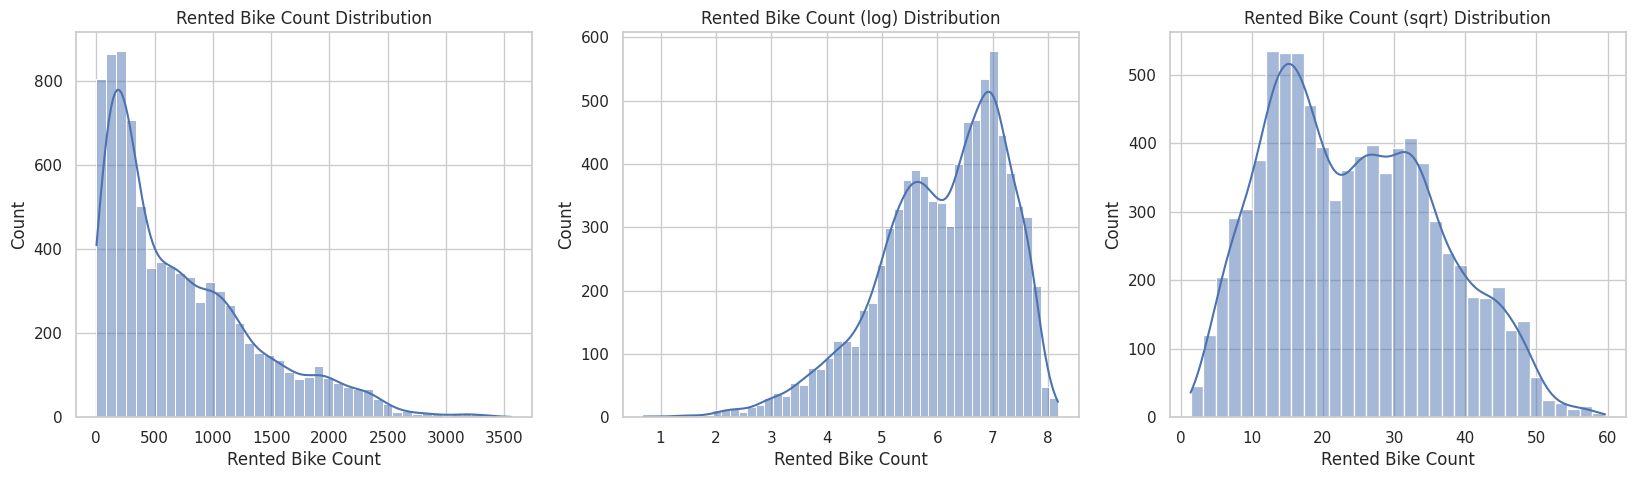

In [ ]:
# Transforming 'Rented Bike Count' to normal
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.histplot(x='Rented Bike Count', data=df2, kde=True)
plt.title("Rented Bike Count Distribution")

plt.subplot(1,3,2)
sns.histplot(np.log(df2['Rented Bike Count']), kde=True)
plt.title("Rented Bike Count (log) Distribution")

plt.subplot(1,3,3)
sns.histplot(np.sqrt(df2['Rented Bike Count']), kde=True)
plt.title("Rented Bike Count (sqrt) Distribution")

In [ ]:
# Transforming Rented Bike Count using np.sqrt
df2['Rented Bike Count'] = np.sqrt(df2['Rented Bike Count'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Transforming Wind Speed using np.sqrt
df2['Wind speed (m/s)_capped'] = np.sqrt(df2['Wind speed (m/s)_capped'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Wind Speed after transformation is approx normally distributed
sns.histplot(x='Wind speed (m/s)_capped', data=df2, kde=True)

NameError: name 'sns' is not defined

### 6. Data Scaling

In [ ]:
df2.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Visibility (10m),Rainfall(mm)_capped,Snowfall(cm)_capped,Wind speed (m/s)_capped,Solar Radiation (MJ/m2)_capped,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,is_weekend
0,15.937377,0,-5.2,37,2000,0.0,0.0,1.483240,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,14.282857,1,-5.5,38,2000,0.0,0.0,0.894427,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,13.152946,2,-6.0,39,2000,0.0,0.0,1.000000,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,10.344080,3,-6.2,40,2000,0.0,0.0,0.948683,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,8.831761,4,-6.0,36,2000,0.0,0.0,1.516575,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Standardizing the required column
df2['Temperature(°C)'] = StandardScaler().fit_transform(df2['Temperature(°C)'].values.reshape(-1, 1))
df2['Humidity(%)'] = StandardScaler().fit_transform(df2['Humidity(%)'].values.reshape(-1, 1))

# Normalizing the required column
df2['Visibility (10m)'] = MinMaxScaler().fit_transform(df2['Visibility (10m)'].values.reshape(-1, 1))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df2.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Visibility (10m),Rainfall(mm)_capped,Snowfall(cm)_capped,Wind speed (m/s)_capped,Solar Radiation (MJ/m2)_capped,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,is_weekend
0,15.937377,0,-1.484762,-1.032395,1.0,0.0,0.0,1.483240,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,14.282857,1,-1.509548,-0.983575,1.0,0.0,0.0,0.894427,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,13.152946,2,-1.550858,-0.934756,1.0,0.0,0.0,1.000000,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,10.344080,3,-1.567382,-0.885937,1.0,0.0,0.0,0.948683,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,8.831761,4,-1.550858,-1.081214,1.0,0.0,0.0,1.516575,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


##### Which method have you used to scale you data and why?

When you are using an algorithm that assumes your features have a similar range, you should use feature scaling.

If the ranges of your features differ much then you should use feature scaling. If the range does not vary a lot like one of them is between 0 and 2 and the other one is between -1 and 0.5 then you can leave them as it's. However, you should use feature scaling if the ranges are, for example, between -2 and 2 and between -100 and 100.

Use Standardization when your data follows Gaussian distribution.
Use Normalization when your data does not follow Gaussian distribution.

So in my data, range of data values for **Temperature(°C)**, **Humidity(%)** and **Visibility (10m)** was large and rest was not. Also Temperature(°C) and Humidity(%) was approx normally distributed hence used **StandardScaler** whereas used **MinMaxScaler** for Visibility (10m).

**NOTE:-** *The '**Hour**' column also does not need scaling, as it represents discrete values from 0 to 23.*

### 7. Dimesionality Reduction

In [ ]:
# Processed Dataset shape (rows, columns)
df2.shape

(8465, 31)

##### Do you think that dimensionality reduction is needed? Explain Why?

With 30 columns (independent features) and 8465 rows, and after doing all the feature engineering steps like removing multicolinearity, feature selection manupulations etc. I don't think I need dimensionality reduction here.

Essentially where high dimensions are a problem or where it is a particular point in the algorithm to dimension reduction.

##### Which dimensionality reduction technique have you used and why? (If dimensionality reduction done on dataset.)

Answer Here.

### 8. Data Splitting

In [ ]:
# Splitting data into 75:25 ratio
X_train, X_test, y_train, y_test = train_test_split(df2.drop("Rented Bike Count", axis=1), df2["Rented Bike Count"], test_size = 0.25, random_state = 0)

# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (6348, 30)
Number transactions y_train dataset:  (6348,)
Number transactions X_test dataset:  (2117, 30)
Number transactions y_test dataset:  (2117,)


## ***7. ML Model Implementation***

### ML Model - 1 - Linear Regression

In [ ]:
# ML Model - 1 Implementation
linear_reg = LinearRegression()

# Fit the Algorithm
linear_reg.fit(X_train, y_train)

# Predict on the model
train_preds = linear_reg.predict(X_train)
test_preds = linear_reg.predict(X_test)

In [ ]:
print("Training Data:")
print("MSE:", mean_squared_error(y_train, train_preds))
print("MAE:", mean_absolute_error(y_train, train_preds))
print("R2 Score:", r2_score(y_train, train_preds))

Training Data:
MSE: 46.133501684092806
MAE: 5.205905172309001
R2 Score: 0.6733246550819512


In [ ]:
mse = mean_squared_error(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print("Testing Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

Testing Data:
MSE: 45.505932037208744
MAE: 5.148391246683523
R2 Score: 0.6719050969245974


In [ ]:
# Dictionary to store different models accuracies
model_results = {}

In [ ]:
# Storing model performance for comparision later
model_results['Linear Regression'] = [r2, mse, mae]

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

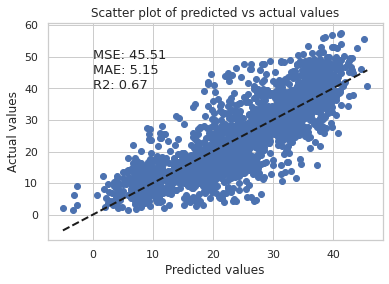

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')

# Add evaluation metrics to plot
plt.text(0, 40, f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}', fontsize=13, ha='left')

plt.show()

I used Linear Regression algorithm to create the model. And the result is not so good.

For training data, I found R2 score of 0.673 & 46.1 and 5.2 as MSE and MAE respectively.

For testing data, I found R2 score of 0.672 & 45.5 and 5.1 as MSE and MAE respectively.

Next trying to improving the score by using hyperparameter tuning technique.

Text(0, 0.5, 'Residuals')

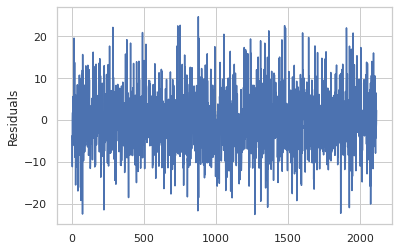

In [ ]:
# Checking Homoscedasticity
residuals = y_test - test_preds

plt.figure(figsize=(6,4))
_ = sns.lineplot(x=list(range(1, len(residuals)+1)), y=residuals)
plt.ylabel('Residuals')

It looks like variance is almost constant, hence fulfilling Homoscedasticity assumption of Linear Regression.

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 1 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
model = LinearRegression()
params = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')

# Fit the Algorithm
grid_search.fit(X_train, y_train)
linear_reg_cv = grid_search.best_estimator_

# Predict on the model
train_preds = linear_reg_cv.predict(X_train)
test_preds = linear_reg_cv.predict(X_test)

In [ ]:
print("Training Data:")
print("MSE:", mean_squared_error(y_train, train_preds))
print("MAE:", mean_absolute_error(y_train, train_preds))
print("R2 Score:", r2_score(y_train, train_preds))

Training Data:
MSE: 46.133501684092806
MAE: 5.205905172309033
R2 Score: 0.6733246550819512


In [ ]:
mse = mean_squared_error(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print("Testing Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

Testing Data:
MSE: 45.505932037209035
MAE: 5.148391246683574
R2 Score: 0.6719050969245952


In [ ]:
# Storing model performance for comparision later
model_results['Linear Regression CV'] = [r2, mse, mae]

##### Which hyperparameter optimization technique have you used and why?

GridSearchCV which uses the Grid Search technique for finding the optimal hyperparameters to increase the model performance.

If we don't have not very large hyperparameter space and training time for the model is not too long then we can go for this technique to find best hyperparameters.

In GridSearchCV, along with Grid Search, cross-validation is also performed. Cross-Validation is used while training the model.

That's why I have used GridSearchCV method for hyperparameter optimization.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

For training data, I found R2 score of 0.673 & 46.1 and 5.2 as MSE and MAE respectively.

For testing data, I found R2 score of 0.672 & 45.5 and 5.1 as MSE and MAE respectively.

For Both training and testing data, **no improvement** is seen.

### ML Model - 2 - Ridge

In [ ]:
# ML Model - 2 Implementation
ridge = Ridge(random_state=0)

# Fit the Algorithm
ridge.fit(X_train, y_train)

# Predict on the model
train_preds = ridge.predict(X_train)
test_preds = ridge.predict(X_test)

In [ ]:
print("Training Data:")
print("MSE:", mean_squared_error(y_train, train_preds))
print("MAE:", mean_absolute_error(y_train, train_preds))
print("R2 Score:", r2_score(y_train, train_preds))

Training Data:
MSE: 46.133548979793986
MAE: 5.206012326411886
R2 Score: 0.6733243201769703


In [ ]:
mse = mean_squared_error(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print("Testing Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

Testing Data:
MSE: 45.508985079069724
MAE: 5.1486982064229005
R2 Score: 0.671883084685124


In [ ]:
model_results['Ridge'] = [r2, mse, mae]

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

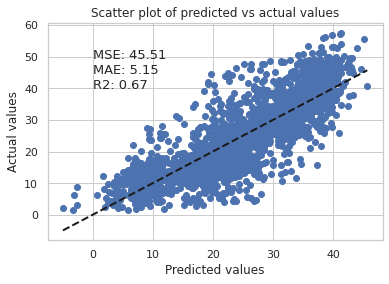

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')

# Add evaluation metrics to plot
plt.text(0, 40, f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}', fontsize=13, ha='left')

plt.show()

I used Ridge Regression algorithm to create the model. And the result is not so good.

For training data, I found R2 score of 0.673 & 46.1 and 5.2 as MSE and MAE respectively.

For testing data, I found R2 score of 0.672 & 45.5 and 5.1 as MSE and MAE respectively.

Next trying to improving the score by using hyperparameter tuning technique.

Text(0, 0.5, 'Residuals')

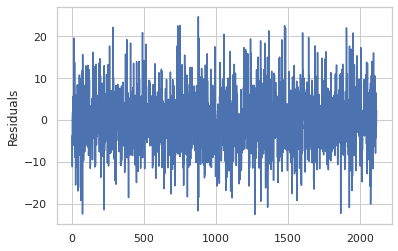

In [ ]:
# Checking Homoscedasticity
residuals = y_test - test_preds

plt.figure(figsize=(6,4))
_ = sns.lineplot(x=list(range(1, len(residuals)+1)), y=residuals)
plt.ylabel('Residuals')

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 2 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
params = {
    'solver':['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 50, 100]
}
ridge_cv = Ridge(random_state=0)
grid_search = GridSearchCV(ridge_cv, params, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)

# Fit the Algorithm
grid_result = grid_search.fit(X_train, y_train)
ridge_cv = grid_search.best_estimator_

# Predict on the model
train_preds = ridge_cv.predict(X_train)
test_preds = ridge_cv.predict(X_test)

In [ ]:
print("Training Data:")
print("MSE:", mean_squared_error(y_train, train_preds))
print("MAE:", mean_absolute_error(y_train, train_preds))
print("R2 Score:", r2_score(y_train, train_preds))

Training Data:
MSE: 46.134450938290236
MAE: 5.20576188242287
R2 Score: 0.673317933330273


In [ ]:
mse = mean_squared_error(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print("Testing Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

Testing Data:
MSE: 45.50021750134879
MAE: 5.147664866601122
R2 Score: 0.671946298368127


In [ ]:
# Slightly Better Performance, updating performance of Ridge
model_results['RidgeCV'] = [r2, mse, mae]

##### Which hyperparameter optimization technique have you used and why?

GridSearchCV which uses the Grid Search technique for finding the optimal hyperparameters to increase the model performance.

If we've don't have very large hyperparameter space and training time for the model is not too long then we can go for this technique to find best hyperparameters.

In GridSearchCV, along with Grid Search, cross-validation is also performed. Cross-Validation is used while training the model.

That's why I have used GridSearchCV method for hyperparameter optimization.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

For training data, I found R2 score of 0.673 & 46.1 and 5.2 as MSE and MAE respectively.

For testing data, I found R2 score of 0.672 & 45.5 and 5.1 as MSE and MAE respectively.

For Both training and testing data, **no improvement** is seen.

#### 3. Explain each evaluation metric's indication towards business and the business impact of the ML model used.

**R2 (R-squared)**: R2 measures how much of the variance in the target variable is explained by the model. A high R2 score indicates that the model is able to capture a large portion of the variance in the target variable, and therefore is a good fit for the data. From a business perspective, a high R2 score can indicate that the model is accurately predicting the target variable, which can be valuable for decision-making purposes.

**MSE (Mean Squared Error)**: MSE measures the average squared difference between the predicted and actual values. A low MSE score indicates that the model's predictions are close to the actual values. From a business perspective, a low MSE score can indicate that the model is making accurate predictions, which can be valuable for decision-making purposes.

**MAE (Mean Absolute Error)**: MAE measures the average absolute difference between the predicted and actual values. Like MSE, a low MAE score indicates that the model's predictions are close to the actual values. However, MAE is less sensitive to outliers than MSE. From a business perspective, a low MAE score can indicate that the model is making accurate predictions across a wide range of values, which can be valuable for decision-making purposes.

Overall, these evaluation metrics can help a business to assess the performance of a machine learning model and its potential impact on business outcomes. By selecting the appropriate metrics and optimizing the model accordingly, businesses can build models that are well-suited to their specific needs and goals.

### ML Model - 3 - Decision Tree Regressor

In [ ]:
# ML Model - 3 Implementation
dtree = DecisionTreeRegressor(max_depth=8, max_features=9, max_leaf_nodes=100, random_state=1)

# Fit the Algorithm
dtree.fit(X_train, y_train)

# Predict on the model
train_preds = dtree.predict(X_train)
test_preds = dtree.predict(X_test)

In [ ]:
print("Training Data:")
print("MSE:", mean_squared_error(y_train, train_preds))
print("MAE:", mean_absolute_error(y_train, train_preds))
print("R2 Score:", r2_score(y_train, train_preds))

Training Data:
MSE: 24.842722999945238
MAE: 3.651390361943899
R2 Score: 0.8240865139550214


In [ ]:
mse = mean_squared_error(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print("Testing Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

Testing Data:
MSE: 31.025877597462657
MAE: 4.0316300846325825
R2 Score: 0.7763053771792781


In [ ]:
model_results['Decision Tree'] = [r2, mse, mae]

#### 1. Explain the ML Model used and it's performance using Evaluation metric Score Chart.

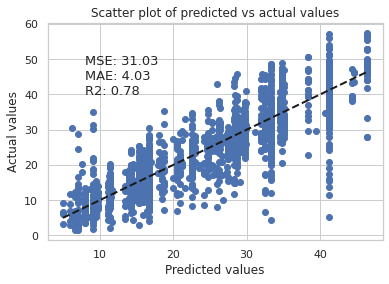

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')

# Add evaluation metrics to plot
plt.text(8, 40, f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}', fontsize=13, ha='left')

plt.show()

I used Decision Tree Regressor algorithm to create the model. And the result is better than previous two linear models.

For training data, I found R2 score of 0.824 & 24.8 and 3.6 as MSE and MAE respectively.

For testing data, I found R2 score of 0.776 & 31.0 and 4.0 as MSE and MAE respectively.

Next trying to improving the score by using hyperparameter tuning technique.

#### 2. Cross- Validation & Hyperparameter Tuning

In [ ]:
# ML Model - 3 Implementation with hyperparameter optimization techniques (i.e., GridSearch CV, RandomSearch CV, Bayesian Optimization etc.)
params = {'max_depth': np.arange(1, 10),
          'min_samples_leaf': [1, 2, 4, 8, 16]
}
dtree_cv = DecisionTreeRegressor(random_state=1)
grid_search = GridSearchCV(dtree_cv, params, cv=5, scoring='neg_mean_squared_error')

# Fit the Algorithm
grid_result = grid_search.fit(X_train, y_train)
dtree_cv = grid_search.best_estimator_

# Predict on the model
train_preds = dtree_cv.predict(X_train)
test_preds = dtree_cv.predict(X_test)

In [ ]:
print("Training Data:")
print("MSE:", mean_squared_error(y_train, train_preds))
print("MAE:", mean_absolute_error(y_train, train_preds))
print("R2 Score:", r2_score(y_train, train_preds))

Training Data:
MSE: 13.408001318671062
MAE: 2.4927585453021774
R2 Score: 0.905056774457925


In [ ]:
mse = mean_squared_error(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)
print("Testing Data:")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

Testing Data:
MSE: 22.34995811187892
MAE: 3.123297683957899
R2 Score: 0.8388582100799443


In [ ]:
model_results['Decision Tree CV'] = [r2, mse, mae]

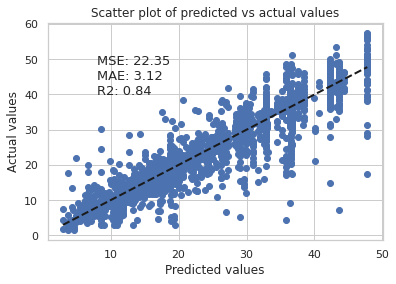

In [ ]:
# Create scatter plot
plt.scatter(test_preds, y_test)
plt.plot([min(test_preds), max(test_preds)], [min(test_preds), max(test_preds)], 'k--', lw=2)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Scatter plot of predicted vs actual values')

# Add evaluation metrics to plot
plt.text(8, 40, f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nR2: {r2:.2f}', fontsize=13, ha='left')

plt.show()

##### Which hyperparameter optimization technique have you used and why?

GridSearchCV which uses the Grid Search technique for finding the optimal hyperparameters to increase the model performance.

If we don't have very large hyperparameter space and training time for the model is not too long then we can go for this technique to find best hyperparameters.

In GridSearchCV, along with Grid Search, cross-validation is also performed. Cross-Validation is used while training the model.

That's why I have used GridSearchCV method for hyperparameter optimization.

##### Have you seen any improvement? Note down the improvement with updates Evaluation metric Score Chart.

For training data, I found R2 score of 0.905 & 13.4 and 2.5 as MSE and MAE respectively.

For testing data, I found R2 score of 0.838 & 22.3 and 3.1 as MSE and MAE respectively.

For Both training and testing data, **quite improvement** is seen.

### 1. Which Evaluation metrics did you consider for a positive business impact and why?

I've used three evaluation metrics R-squared ($R^2$), Mean Squared Error ($MSE$) and Mean Absolute Error ($MAE$).

* $R^2$ measures how much of the variance in the target variable is explained by the model. A high $R^2$ score indicates that the model is able to capture a large portion of the variance in the target variable, and therefore is a good fit for the data. From a business perspective, a high $R^2$ score can indicate that the model is accurately predicting the target variable, which can be valuable for decision-making purposes.

* $MSE$ measures the average squared difference between the predicted and actual values. A low $MSE$ score indicates that the model's predictions are close to the actual values. From a business perspective, a low $MSE$ score can indicate that the model is making accurate predictions, which can be valuable for decision-making purposes.

* $MAE$ measures the average absolute difference between the predicted and actual values. Like MSE, a low $MAE$ score indicates that the model's predictions are close to the actual values. However, $MAE$ is less sensitive to outliers than $MSE$. From a business perspective, a low $MAE$ score can indicate that the model is making accurate predictions across a wide range of values, which can be valuable for decision-making purposes.

Hence, these evaluation metrics can help a business to assess the performance of a machine learning model and its potential impact on business outcomes.

### 2. Which ML model did you choose from the above created models as your final prediction model and why?

The XGBoost model (CV: which is hyperparameter optimized) seems to be the best choice for this dataset as it has the highest $R^2$ score, the lowest $MSE$, and the lowest $MAE$. As shown in figure table:

In [ ]:
Model_com_df = pd.DataFrame(model_results).T
Model_com_df.columns = ["R2", 'MSE', 'MAE']
Model_com_df = Model_com_df.sort_values(by='R2',ascending=False)
Model_com_df.style.format('{:.3f}').background_gradient(cmap='RdYlGn')

,R2,MSE,MAE
XGBoost CV,0.940,8.356,1.755
XGBoost,0.932,9.397,1.890
Random Forest,0.920,11.027,2.031
Random Forest CV,0.919,11.295,2.077
Decision Tree CV,0.839,22.350,3.123
Decision Tree,0.776,31.026,4.032
RidgeCV,0.672,45.500,5.148
Linear Regression,0.672,45.506,5.148
Linear Regression CV,0.672,45.506,5.148
Ridge,0.672,45.509,5.149


The above metrics scores are on test data.

### 3. Explain the model which you have used and the feature importance using any model explainability tool?

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


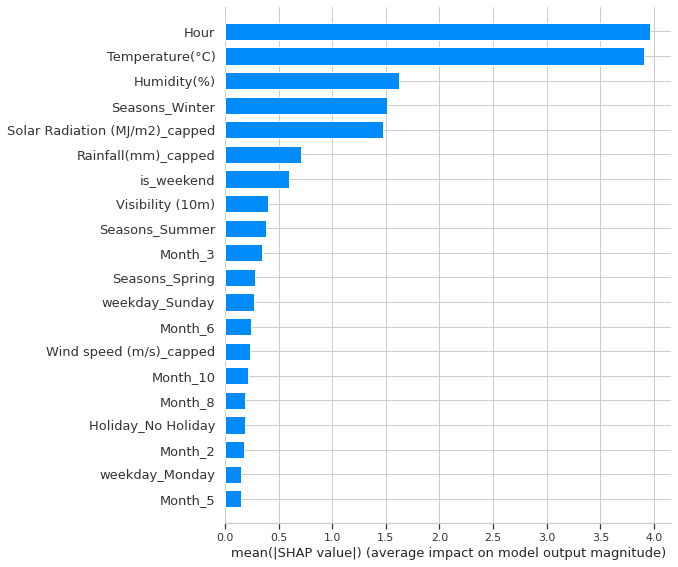

In [ ]:
# Create a SHAP Explainer object
explainer = shap.Explainer(xgb_model_cv)

# Calculate SHAP values for all features
shap_values = explainer(X_test)

# Plot the feature importance using a bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

A SHAP summary plot shows the overall importance of each feature in a machine learning model. It can be used to identify the most important features that are driving the model's predictions and gain insights into how those features are influencing the predictions.

We can see that **Hour** and **Temperature** are the two most important feature to predict rental bike demand, then followed by **Humidity**, **Season_Winter**, **Solar Radiation**, **Rainfall** etc.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


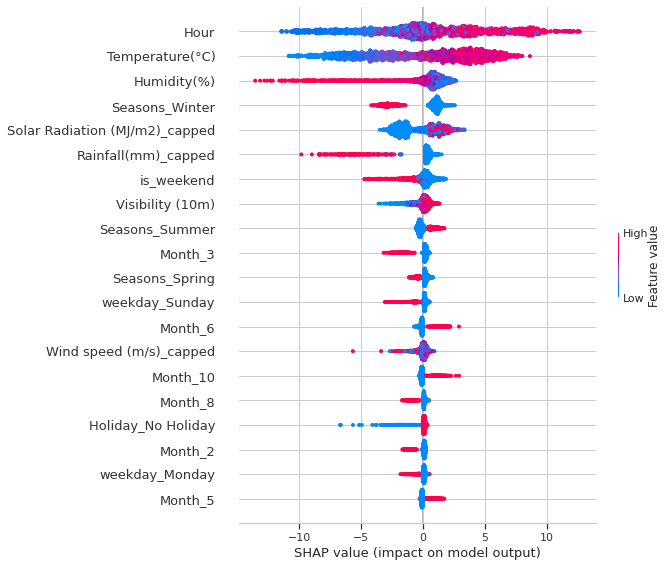

In [ ]:
shap.summary_plot(shap_values, X_test)

Above plot is another way to visualise SHAP values. this plot not only shows which feature is most important but also the positive-negative impact of different values of features. For example, we can see that high values of both **Hour** and **Temperature** has *positive impact* on model output, whereas high values of both **Humidity** and **rainfall** has *negative impact* on model output.

## ***8.*** ***Future Work (Optional)***

### 1. Save the best performing ml model in a pickle file or joblib file format for deployment process.


In [ ]:
# Save the model to a pickle file
with open("xgb_model.pkl", "wb") as f:
  pickle.dump(xgb_model_cv, f)

### 2. Again Load the saved model file and try to predict unseen data for a sanity check.


In [ ]:
# Load the model from the pickle file
with open("xgb_model.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)

new_test_preds = loaded_xgb_model.predict(X_test)

# Sanity Check
mse = mean_squared_error(y_test, new_test_preds)
mae = mean_absolute_error(y_test, new_test_preds)
r2 = r2_score(y_test, new_test_preds)
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

MSE: 8.356347780811166
MAE: 1.7552048461763605
R2 Score: 0.9397512589574516


### ***Congrats! Your model is successfully created and ready for deployment on a live server for a real user interaction !!!***

# **Conclusion**

1. Here are some solution to increase Rental Bike Demands:

>* Marketing campaigns: Launch targeted marketing campaigns during seasons when the demand for bike rentals is low, such as winter, to increase awareness and encourage people to rent bikes.

>* Seasonal pricing: Offer seasonal pricing strategies to encourage customers to rent bikes during low demand seasons.

>* Location-based pricing: Consider implementing dynamic pricing strategies based on the location of the bike rental stations. Higher demand locations can have higher pricing to ensure that bikes are available for customers in low demand locations.

>* Increasing visibility: Improving visibility of bike rental stations as well as installing lights on the bike can attract more customers even when visibility is low. Consider installing better signage, increasing lighting or even painting the stations in bright colours to increase their visibility.

>* Offering incentives: Offer incentives such as loyalty programs, discounts, and referral programs to encourage customers to rent bikes and refer friends to do the same.

2. Demand for bike rentals is highest during the summer months (May, June, July) and lowest during the winter months (December, January, February).

3. Demand is highest during rush hour, with a peak in the morning (8-10 am) and the evening (5-7 pm).

4. Temperature have a significant impact on demand, with demand increasing as the temperature increases up to a certain point (around 30°C for temperature).

5. Rainfall and snowfall have a negative impact on demand, with demand decreasing as the amount of rainfall or snowfall increases.

6. Demand is lower on holidays compared to non-holidays.

7. XGBoost model performed best for predicting bike rental demand, with XGBoost CV having the highest $R^2$ score **0.94** and the lowest $MSE$ **8.356** and lowest $MAE$ **1.755**.

8. Feature importance analysis using SHAP values showed that the most important features for predicting bike rental demand were hour of the day, temperature, humidity, and dew point temperature.

### ***Hurrah! You have successfully completed your Machine Learning Capstone Project !!!***